# Laplace equation

$$
\nabla^2 u = 0
$$


In [2]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

First a very easy case with the analytical solution u = x

Epoch 0, Total Loss: 4.960E+01, Domain Loss: 9.178E-04, Boundary Loss Dirichlet: 7.917E-02


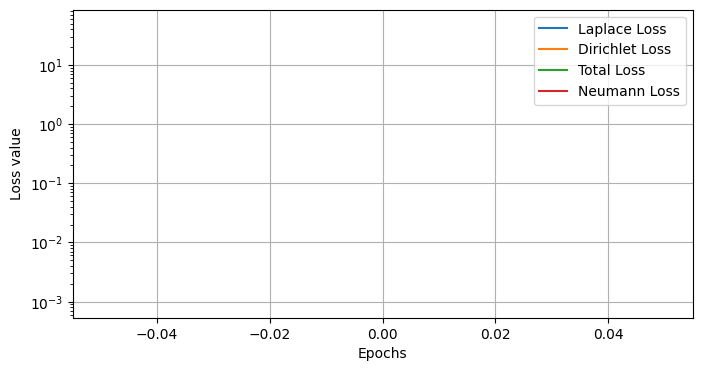

Epoch 10, Total Loss: 1.574E-02, Domain Loss: 1.139E-06, Boundary Loss Dirichlet: 5.295E-07


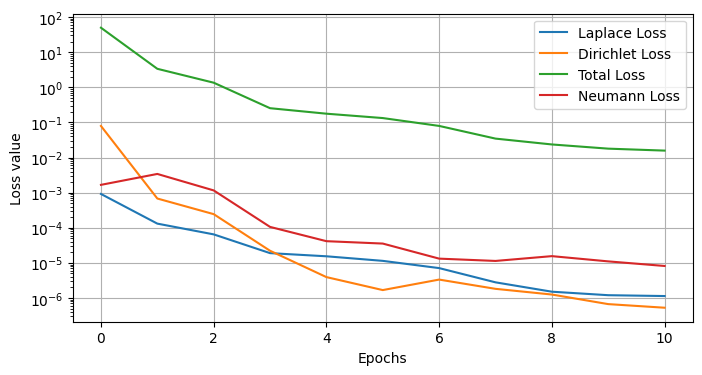

Epoch 20, Total Loss: 3.669E-04, Domain Loss: 3.386E-08, Boundary Loss Dirichlet: 8.123E-09


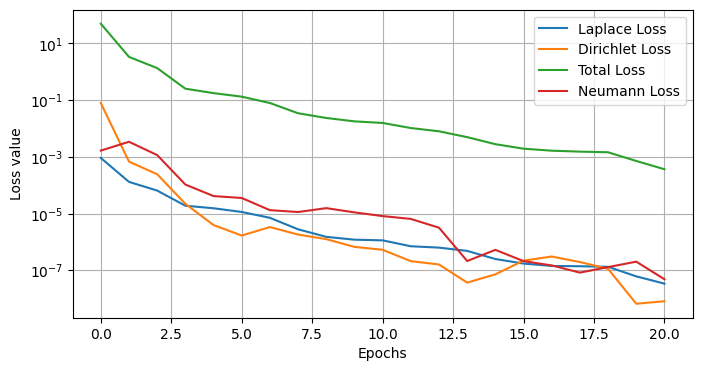

Epoch 30, Total Loss: 1.202E-04, Domain Loss: 1.095E-08, Boundary Loss Dirichlet: 1.429E-08


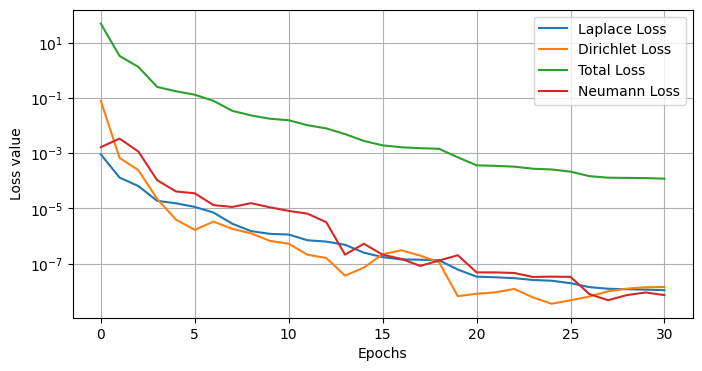

Epoch 40, Total Loss: 7.592E-05, Domain Loss: 7.262E-09, Boundary Loss Dirichlet: 4.303E-10


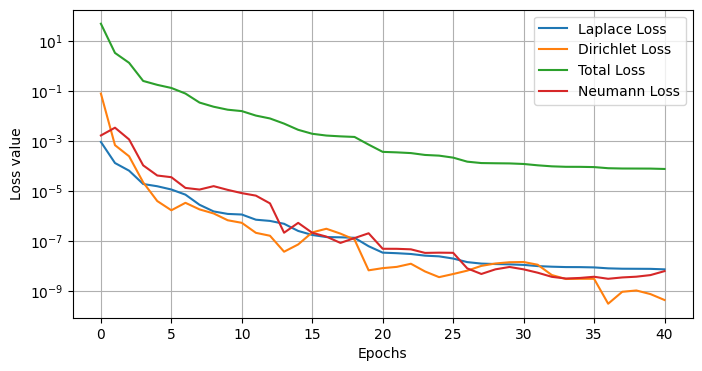

Epoch 50, Total Loss: 2.377E-05, Domain Loss: 1.427E-09, Boundary Loss Dirichlet: 2.326E-09


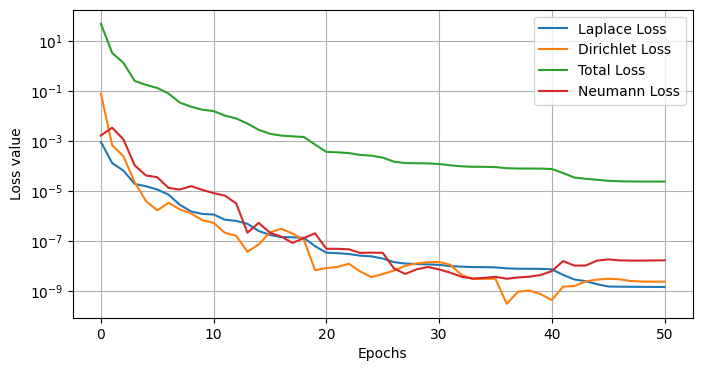

Epoch 60, Total Loss: 1.256E-05, Domain Loss: 9.326E-10, Boundary Loss Dirichlet: 3.393E-09


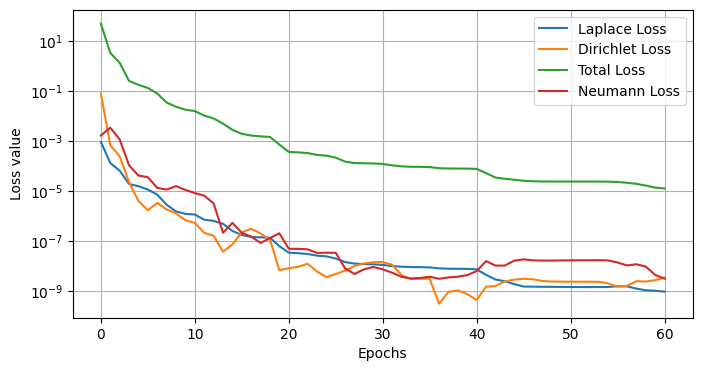

Epoch 70, Total Loss: 5.294E-06, Domain Loss: 4.395E-10, Boundary Loss Dirichlet: 5.231E-10


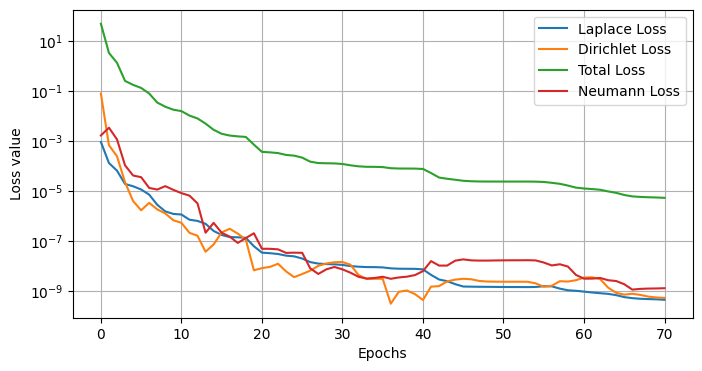

In [2]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

def loss_neumann_boundary(model,boundary_points,axis='horizontal'):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
    if axis=='vertical':
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    elif axis=='horizontal':
        u_y = u_grad[:,1] # This is the y-component of the gradient of u
        return torch.mean((u_y)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head=None):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    if head is not None:
        boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
        return boundary_points, boundary_targets
    else:
        return boundary_points
    
def plot_losses(epochs, laplace_losses, dirichlet_losses, neumann_losses, total_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, laplace_losses, label="Laplace Loss")
    plt.plot(epochs, dirichlet_losses, label="Dirichlet Loss")
    plt.plot(epochs, total_losses, label="Total Loss")
    plt.plot(epochs, neumann_losses, label="Neumann Loss")
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()
#_____________________________________________________________________________________________________________

# Boundary points and targets storage
boundary_points_dirichlet = []
boundary_target_dirichlet = []
boundary_points_neumann = []

# Dirichlet boundary conditions
dirichlet_boundaries = [
    ('vertical', 0, 0, 1, 1000, 0),  # Left boundary
    ('vertical', 1, 0, 1, 1000, 1),  # Right boundary
    # ('horizontal', 0, 0, 1, 100, 1),  # Bottom boundary
    # ('horizontal', 1, 0, 1, 100, 0)   # Top boundary
]

for axis, place, start, end, num_points, head in dirichlet_boundaries:
    boundary_points, boundary_targets = create_boundary_points(axis, place, start, end, num_points, head)
    boundary_points_dirichlet.append(boundary_points)
    boundary_target_dirichlet.append(boundary_targets)

# Concatenate Dirichlet boundary points and targets
boundary_points_dirichlet = torch.cat(boundary_points_dirichlet, dim=0).requires_grad_(True)
boundary_target_dirichlet = torch.cat(boundary_target_dirichlet, dim=0)

# Neumann boundary conditions
neumann_boundaries = [
    # ('vertical', 0, 0, 1, 100),  # Left boundary
    # ('vertical', 1, 0, 1, 100),  # Right boundary
    ('horizontal', 0, 0, 1, 1000),  # Bottom boundary
    ('horizontal', 1, 0, 1, 1000)   # Top boundary
]

for axis, place, start, end, num_points in neumann_boundaries:
    boundary_points = create_boundary_points(axis, place, start, end, num_points)
    boundary_points_neumann.append(boundary_points)

# Concatenate Neumann boundary points
boundary_points_neumann = torch.cat(boundary_points_neumann, dim=0).requires_grad_(True)

# Creating domain points
num_domain_points=1000
x = torch.rand((num_domain_points,1),requires_grad=True) #Need to be changed to the actual domain
y = torch.rand((num_domain_points,1),requires_grad=True) #Need to be changed to the actual domain
train_points=torch.cat([x,y],dim=1) 

# Initialize lists to store losses and plot
laplace_losses = []
dirichlet_losses = []
neumann_losses = []
total_losses = []
epochs_recorded = []



#Defining changeable parameters:
model=pinn(hidden_size=64, hidden_layers=3) # to be used for evaluating u at boundaries and inside the domain
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20) #Using the Adam optimizer
lambda_laplace, lambda_dirichlet, lambda_neumann = 10000,500,500  #Weights for the losses
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)
epochs=80

#Training loop:
for epoch in range(epochs):
    # optimizer.zero_grad() #Have to zero the gradients at the start of each epoch

    
    # Backward pass
    # loss.backward()
    # Update 
    
    def closure():
        optimizer.zero_grad()  # Clear previous gradients
        loss_laplace = laplace_residual(model, train_points)
        loss_dirichlet = loss_dirichlet_boundary(model, boundary_points_dirichlet, boundary_target_dirichlet)
        loss_neumann = loss_neumann_boundary(model, boundary_points_neumann, axis='horizontal')

        # Add other boundary losses if needed
        total_loss =loss_laplace * lambda_laplace  + loss_dirichlet * lambda_dirichlet + loss_neumann * lambda_neumann
        
        total_loss.backward()  # Compute gradients
        return total_loss

    # Step with LBFGS, passing in the closure

    optimizer.step(closure)    

    #losses
    loss_laplace=laplace_residual(model,train_points)
    loss_dirichlet = loss_dirichlet_boundary(model, boundary_points_dirichlet, boundary_target_dirichlet)
    loss_neumann = loss_neumann_boundary(model, boundary_points_neumann, axis='horizontal')
    loss=loss_laplace * lambda_laplace  + loss_dirichlet * lambda_dirichlet + loss_neumann * lambda_neumann
    # Append losses to the lists
    laplace_losses.append(loss_laplace.item()) 
    dirichlet_losses.append(loss_dirichlet.item())
    neumann_losses.append(loss_neumann.item())
    total_losses.append(loss.item())
    epochs_recorded.append(epoch) 

    # scheduler.step(loss)

    # Logging
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.3E}, Domain Loss: {loss_laplace.item():.3E}, Boundary Loss Dirichlet: {loss_dirichlet.item():.3E}")
        plot_losses(epochs_recorded, laplace_losses, dirichlet_losses, neumann_losses, total_losses)

c:\Users\jolu2\H24\venv_torch\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


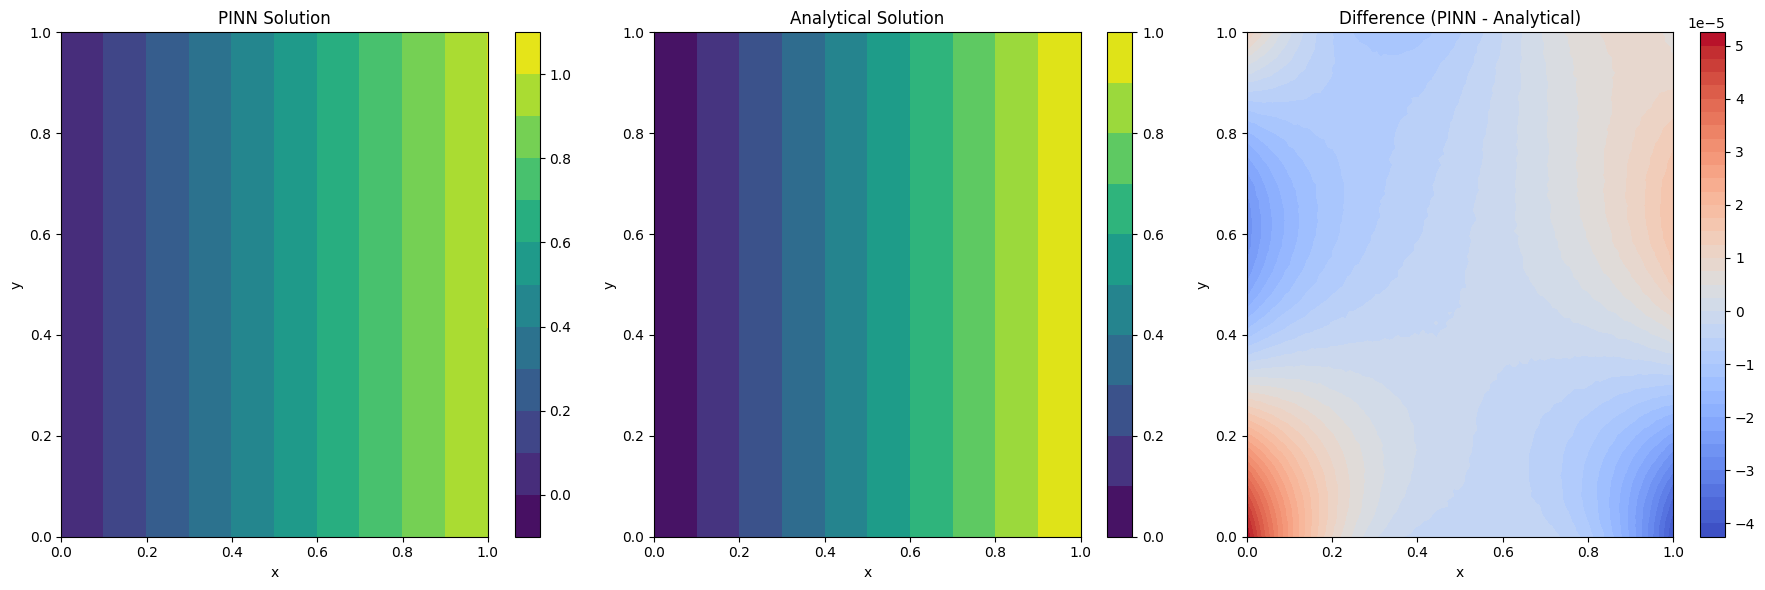

Maximum absolute difference: 5.201E-05, Mean absolute difference: 7.210E-06


In [3]:
# Define the grid
num = 100
x = y = torch.linspace(0, 1, num)
X, Y = torch.meshgrid(x, y)
test_points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Assume `model` is your trained PINN model

# PINN solution
u_predicted = model(test_points).detach().numpy().reshape(num, num)  # Convert to numpy array for plotting

# Analytical solution
u_analytical = X.numpy()  # Linear solution u(x, y) = x, independent of y

# Difference between PINN solution and analytical solution
u_difference = u_predicted - u_analytical

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: PINN Solution
c1 = axs[0].contourf(X.numpy(), Y.numpy(), u_predicted, levels=10, cmap="viridis")
fig.colorbar(c1, ax=axs[0])
axs[0].set_title("PINN Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# Plot 2: Analytical Solution
c2 = axs[1].contourf(X.numpy(), Y.numpy(), u_analytical, levels=10, cmap="viridis")
fig.colorbar(c2, ax=axs[1])
axs[1].set_title("Analytical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

# Plot 3: Difference (PINN - Analytical)
c3 = axs[2].contourf(X.numpy(), Y.numpy(), u_difference, levels=40, cmap="coolwarm")
fig.colorbar(c3, ax=axs[2])
axs[2].set_title("Difference (PINN - Analytical)")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")

plt.tight_layout()  # Adjust layout to reduce whitespace
plt.show()

print(f"Maximum absolute difference: {np.abs(u_difference).max():.3E}, Mean absolute difference: {np.abs(u_difference).mean():.3E}")


## Rekorder

#### Optimizer = Adam

Maximum absolute difference: 6.852E-04, Mean absolute difference: 1.044E-04
Parametere:
- Epochs = 5001
- Size= 20*4
- Activation = tanH
- lr= 0.001
- Domain_points = 1000
- Boundary_points = 100
- Lambda laplace, dirichtlet, neumann = 1, 1, 1

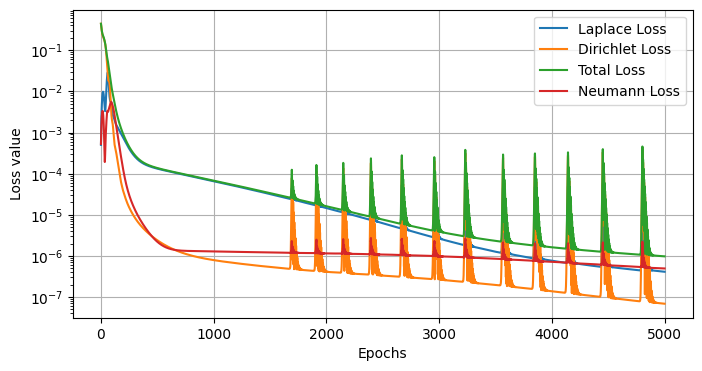

### Optimizer = LBFGS

- Max_iter=20
Maximum absolute difference: 5.156E-05, Mean absolute difference: 6.996E-06
Parametere:
- Epochs = 75
- Size= 64*3
- Activation = tanH
- lr= 0.1
- Domain_points = 1000
- Dirichlet_points = 1000
- Neumann_points = 1000
- Lambda laplace, dirichtlet, neumann = 10000, 500, 500

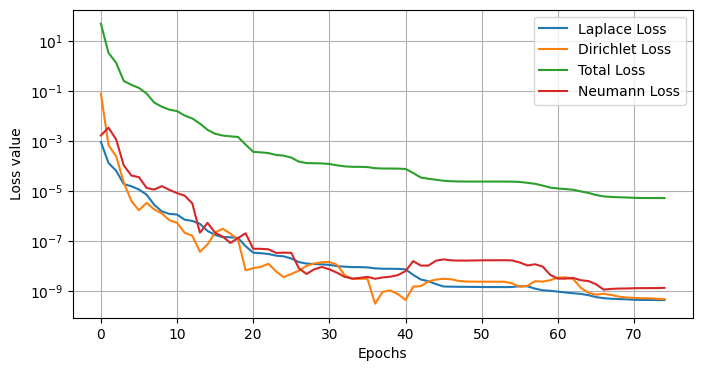

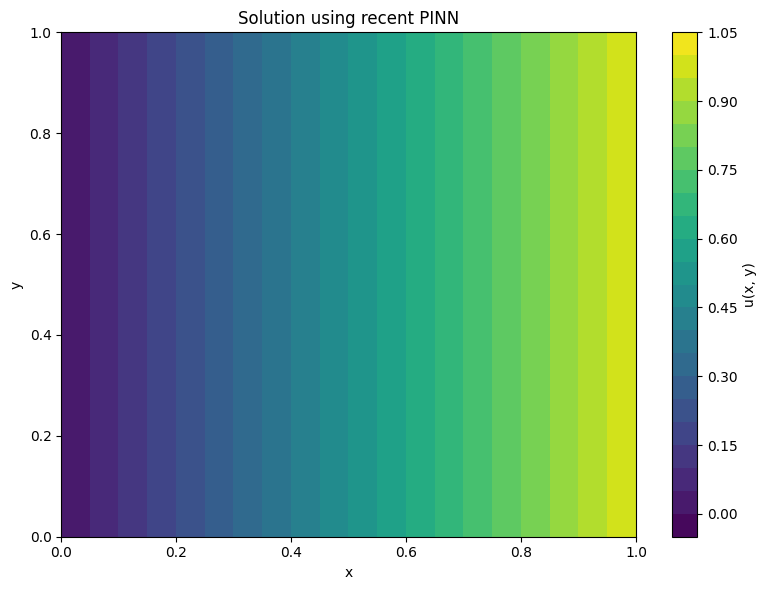

In [4]:
# Plot the results
num=1000
x = y = torch.linspace(0, 1, num)
X, Y = torch.meshgrid(x, y)
test_points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# PINN solution
predicted_u = model(test_points).detach().numpy().reshape(num, num) #detach, numpy are used to convert the tensor to numpy array, reshape to coordinates.

plt.figure(figsize=(8, 6))

# PINN solution plot
plt.contourf(X.numpy(), Y.numpy(), predicted_u, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution using recent PINN")

plt.tight_layout()
plt.show()

A more advanced problem with more challanging boundaries:

In [ ]:
def analytical_solution_dirichlet_square(x, y, U=1.0, L=1.0, num_terms=100):
    """
    Computes the analytical solution of the Laplace equation on a square domain
    with Dirichlet boundary conditions on all sides: fixed potential on the top boundary, zero elsewhere.

    Parameters:
        x (np.ndarray): x-coordinates (2D array)
        y (np.ndarray): y-coordinates (2D array)
        U (float): Potential difference (default is 1.0 for top boundary)
        L (float): Side length of the square (default is 1.0)
        num_terms (int): Number of terms in the series for approximation (default is 100)

    Returns:
        np.ndarray: Analytical solution for u(x, y) on the given grid
    """
    u = np.zeros_like(x)
    for n in range(num_terms):
        term = (1 / (2 * n + 1)) * \
               (np.sinh((2 * n + 1) * np.pi * x / L) / np.sinh((2 * n + 1) * np.pi)) * \
               np.sin((2 * n + 1) * np.pi * y / L)
        u += term
    u *= (4 * U / np.pi)
    return u

# Define grid
L = 1.0
Nx, Ny = 100, 100
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

# Compute solution
U = 10.0
u = analytical_solution_dirichlet_square(X, Y, U=U, L=L, num_terms=100)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u, 50, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution of Laplace Equation on a Square Domain with Dirichlet Boundary Conditions")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Domain
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Analytical solution using multiple terms in the Fourier series
u = np.zeros_like(X)
num_terms = 200  # Increase for higher accuracy

for n in range(1, num_terms + 1, 2):  # Sum over odd terms
    term = (4 / (np.pi * n)) * np.sin(n * np.pi * X) * np.sinh(n * np.pi * Y) / np.sinh(n * np.pi)
    u += term

# Plotting the solution
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, u, levels=50, cmap="viridis")
plt.colorbar(cp, label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution with Fourier Series")

# Set equal aspect ratio and limits
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()


## Simple example with stationary flow

Epoch 0, Total Loss: 4.796E+03, Domain Loss: 7.815E-04, Boundary Loss Dirichlet: 4.794E-01


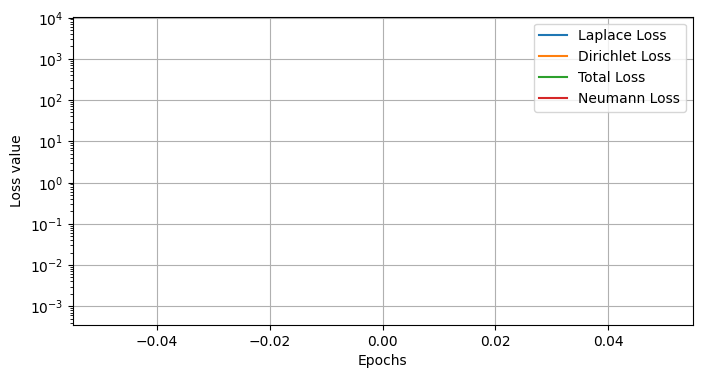

Epoch 500, Total Loss: 1.087E+02, Domain Loss: 1.252E-02, Boundary Loss Dirichlet: 1.027E-02


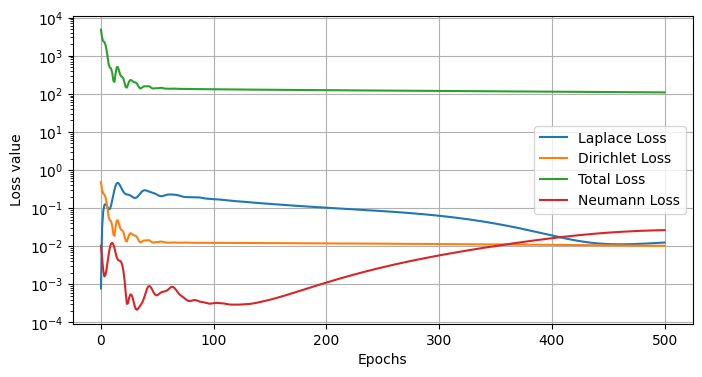

Epoch 1000, Total Loss: 4.178E+01, Domain Loss: 9.418E-02, Boundary Loss Dirichlet: 2.315E-03


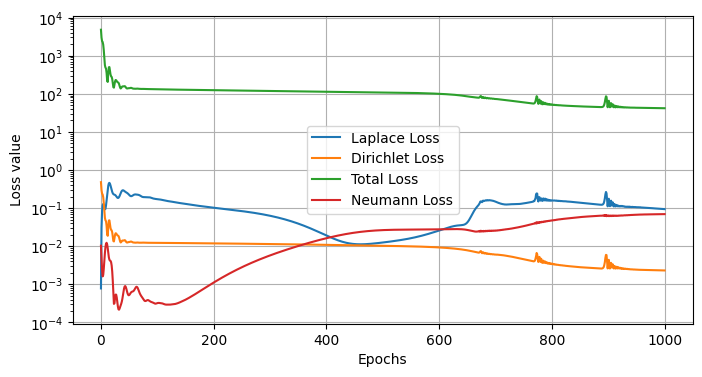

Epoch 1500, Total Loss: 3.691E+01, Domain Loss: 4.121E-02, Boundary Loss Dirichlet: 1.989E-03


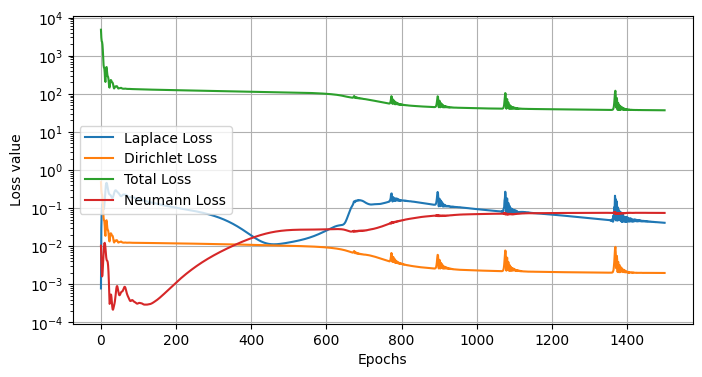

Epoch 2000, Total Loss: 3.465E+01, Domain Loss: 2.504E-02, Boundary Loss Dirichlet: 1.881E-03


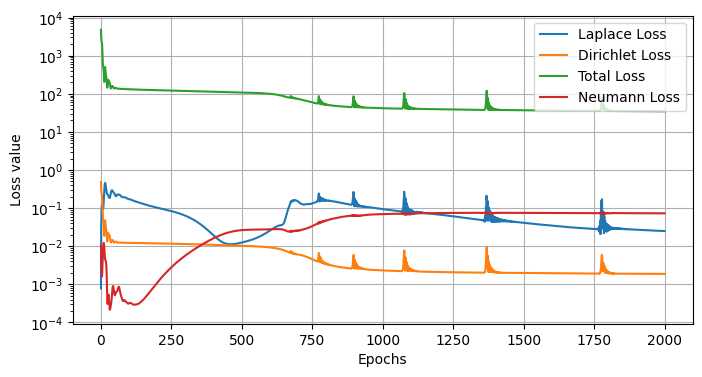

In [5]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

def loss_neumann_boundary(model,boundary_points,axis='horizontal'):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
    if axis=='vertical':
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    elif axis=='horizontal':
        u_y = u_grad[:,1] # This is the y-component of the gradient of u
        return torch.mean((u_y)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head=None):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    if head is not None:
        boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
        return boundary_points, boundary_targets
    else:
        return boundary_points
    
def plot_losses(epochs, laplace_losses, dirichlet_losses, neumann_losses, total_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, laplace_losses, label="Laplace Loss")
    plt.plot(epochs, dirichlet_losses, label="Dirichlet Loss")
    plt.plot(epochs, total_losses, label="Total Loss")
    plt.plot(epochs, neumann_losses, label="Neumann Loss")
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()
#_____________________________________________________________________________________________________________

#Domain size:
left, right, bottom, top = 0, 1, 0, 0.2

# Boundary points and targets storage
boundary_points_dirichlet = []
boundary_target_dirichlet = []
boundary_points_neumann = []

# Dirichlet boundary conditions
dirichlet_boundaries = [
    ('vertical', left, 0, top, 1000, 1),  # Left boundary
    ('vertical', right, 0, top, 1000, 0),  # Right boundary
    # ('horizontal', bottom, 0, right, 1000, 1),  # Bottom boundary
    ('horizontal', top, 0, 0.3*right, 1000, 1),   # Top boundary]
    ('horizontal', top, 0.7*right, 1*right, 1000, 0)   # Top boundary
]

for axis, place, start, end, num_points, head in dirichlet_boundaries:
    boundary_points, boundary_targets = create_boundary_points(axis, place, start, end, num_points, head)
    boundary_points_dirichlet.append(boundary_points)
    boundary_target_dirichlet.append(boundary_targets)

# Concatenate Dirichlet boundary points and targets
boundary_points_dirichlet = torch.cat(boundary_points_dirichlet, dim=0).requires_grad_(True)
boundary_target_dirichlet = torch.cat(boundary_target_dirichlet, dim=0)

# Neumann boundary conditions
neumann_boundaries = [
    # ('vertical', left, 0, top, 100),  # Left boundary
    # ('vertical', right, 0, top, 100),  # Right boundary
    ('horizontal', bottom, 0, right, 1000),  # Bottom boundary
    ('horizontal', top, 0.3*right, 0.7*right, 1000)   # Top boundary
]

for axis, place, start, end, num_points in neumann_boundaries:
    boundary_points_n = create_boundary_points(axis, place, start, end, num_points)
    boundary_points_neumann.append(boundary_points_n)

# Concatenate Neumann boundary points
boundary_points_neumann = torch.cat(boundary_points_neumann, dim=0).requires_grad_(True)

# Creating domain points
num_domain_points=1000
x_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
x = (x_points*right).requires_grad_(True)
y_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
y=(y_points*top).requires_grad_(True)
train_points=torch.cat([x,y],dim=1) 

# Initialize lists to store losses and plot
laplace_losses = []
dirichlet_losses = []
neumann_losses = []
total_losses = []
epochs_recorded = []



#Defining changeable parameters:
model=pinn(hidden_size=128, hidden_layers=3) # to be used for evaluating u at boundaries and inside the domain
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Using the Adam optimizer #amsgrad=True
lambda_laplace, lambda_dirichlet, lambda_neumann = 50,10000,200  #Weights for the losses
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)
epochs=2001

#Training loop:
for epoch in range(epochs):
    optimizer.zero_grad() #Have to zero the gradients at the start of each epoch
    # optimizer.zero_grad() #Have to zero the gradients at the start of each epoch
    
    # # # def closure():
    # # #     optimizer.zero_grad()  # Clear previous gradients
    # # #     loss_laplace = laplace_residual(model, train_points)
    # # #     loss_dirichlet = loss_dirichlet_boundary(model, boundary_points_dirichlet, boundary_target_dirichlet)
    # # #     loss_neumann = loss_neumann_boundary(model, boundary_points_neumann, axis='horizontal')

    # # #     # Add other boundary losses if needed
    # # #     total_loss =loss_laplace * lambda_laplace  + loss_dirichlet * lambda_dirichlet + loss_neumann * lambda_neumann
        
    # # #     total_loss.backward()  # Compute gradients
    # # #     return total_loss

    # # # # Step with LBFGS, passing in the closure

    # # # optimizer.step(closure)

    #losses
    loss_laplace=laplace_residual(model,train_points)
    loss_dirichlet = loss_dirichlet_boundary(model, boundary_points_dirichlet, boundary_target_dirichlet)
    loss_neumann = loss_neumann_boundary(model, boundary_points_neumann, axis='horizontal')
    loss = loss_dirichlet * lambda_dirichlet + loss_laplace * lambda_laplace + loss_neumann * lambda_neumann
    # Backward pass
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #Clipping the gradients
    optimizer.step() # Update

    # Append losses to the lists
    laplace_losses.append(loss_laplace.item()) 
    dirichlet_losses.append(loss_dirichlet.item())
    neumann_losses.append(loss_neumann.item())
    total_losses.append(loss.item())
    epochs_recorded.append(epoch) 

    # scheduler.step(loss)

    # Logging
    if epoch % 500 == 0:
        #Add points:
        
        print(f"Epoch {epoch}, Total Loss: {loss.item():.3E}, Domain Loss: {loss_laplace.item():.3E}, Boundary Loss Dirichlet: {loss_dirichlet.item():.3E}")
        plot_losses(epochs_recorded, laplace_losses, dirichlet_losses, neumann_losses, total_losses)

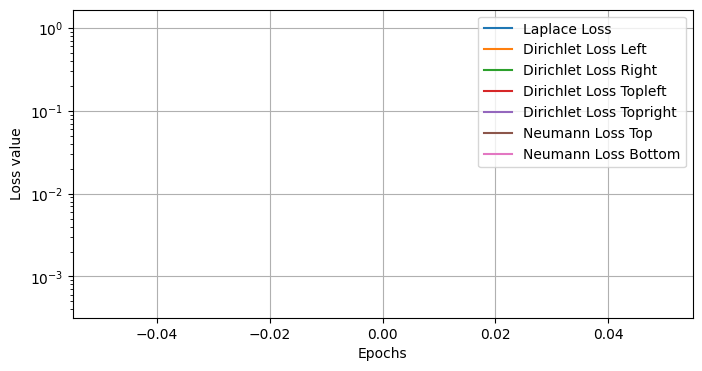

Epoch 0, Total Loss: 1.309E+03, Domain Loss: 2.117E-01, Boundary Loss Dirichlet toppleft: 1.131E+00


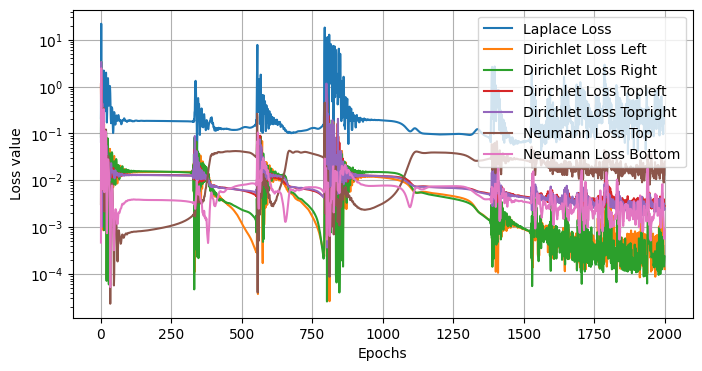

Epoch 2000, Total Loss: 1.154E+01, Domain Loss: 3.630E-01, Boundary Loss Dirichlet toppleft: 2.784E-03


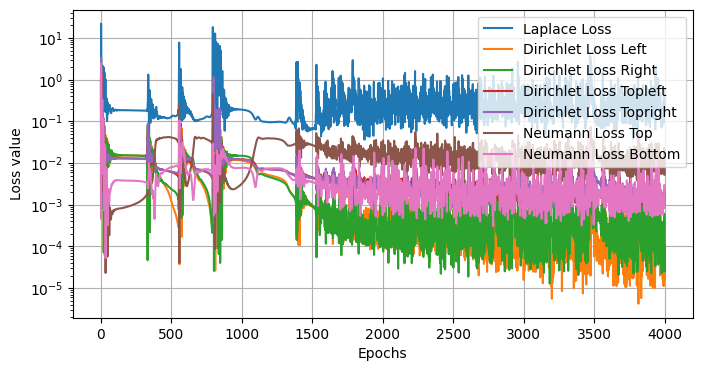

Epoch 4000, Total Loss: 1.040E+01, Domain Loss: 5.971E-01, Boundary Loss Dirichlet toppleft: 1.898E-03


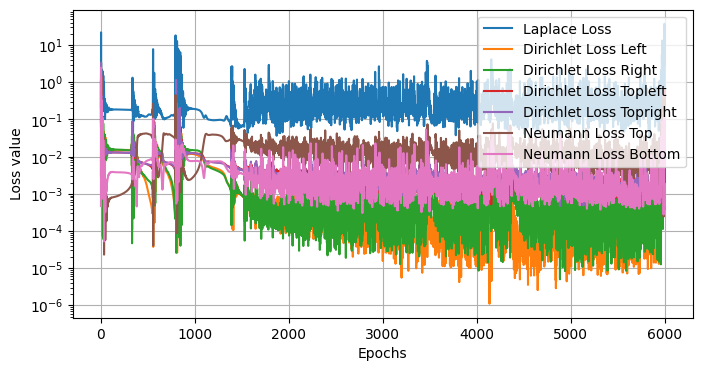

Epoch 6000, Total Loss: 7.255E+02, Domain Loss: 3.769E+01, Boundary Loss Dirichlet toppleft: 2.173E-01


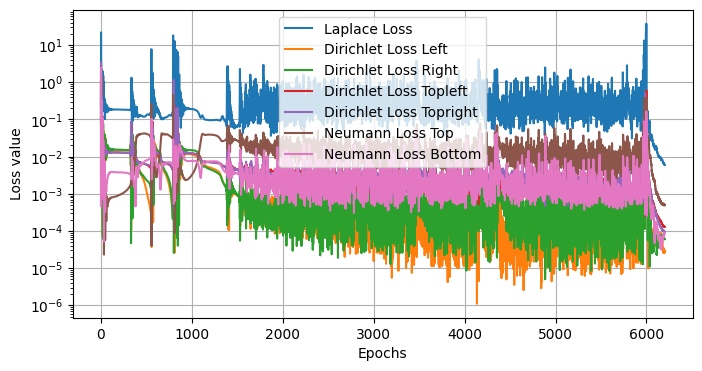

Epoch 6200, Total Loss: 7.255E+02, Domain Loss: 3.769E+01, Boundary Loss Dirichlet toppleft: 2.173E-01


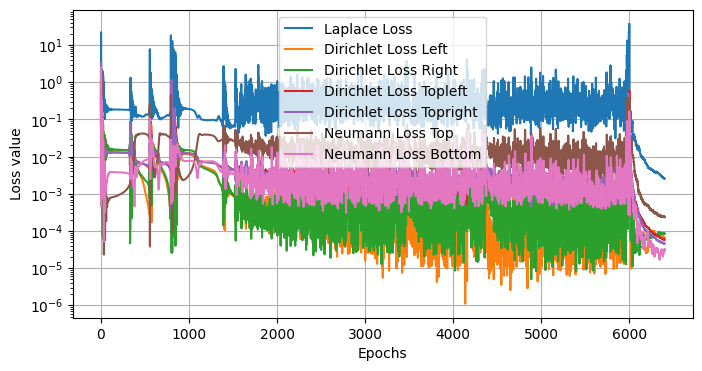

Epoch 6400, Total Loss: 7.255E+02, Domain Loss: 3.769E+01, Boundary Loss Dirichlet toppleft: 2.173E-01


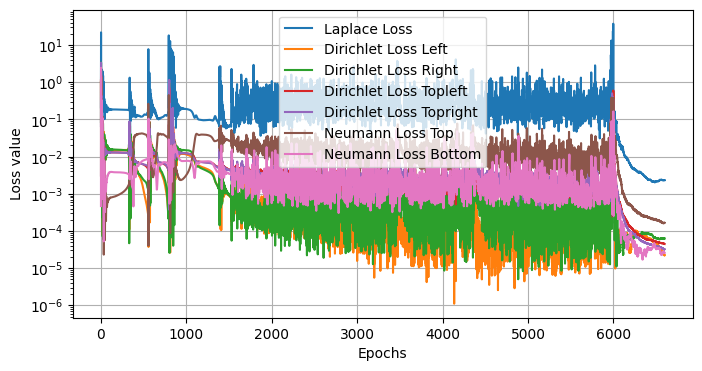

Epoch 6600, Total Loss: 7.255E+02, Domain Loss: 3.769E+01, Boundary Loss Dirichlet toppleft: 2.173E-01


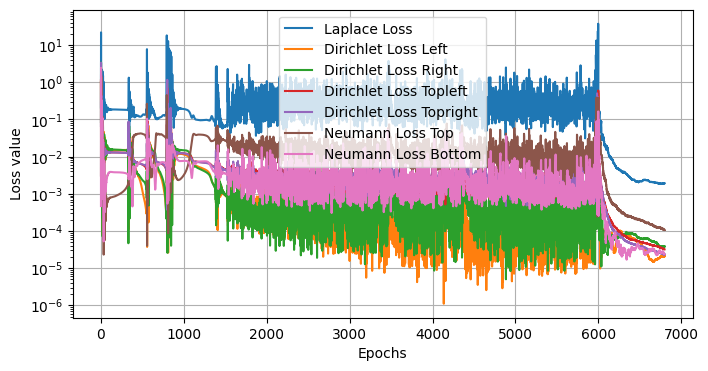

Epoch 6800, Total Loss: 7.255E+02, Domain Loss: 3.769E+01, Boundary Loss Dirichlet toppleft: 2.173E-01


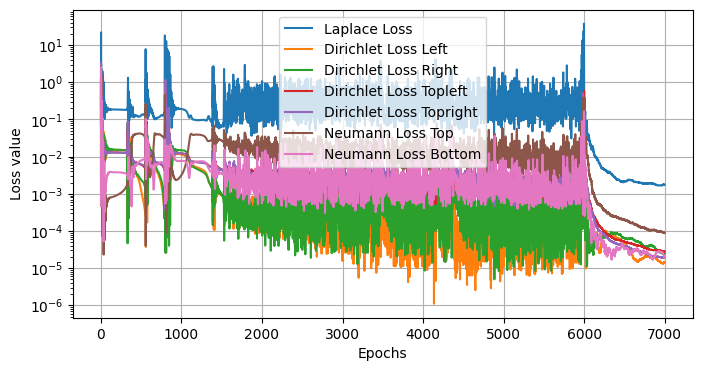

Epoch 7000, Total Loss: 7.255E+02, Domain Loss: 3.769E+01, Boundary Loss Dirichlet toppleft: 2.173E-01


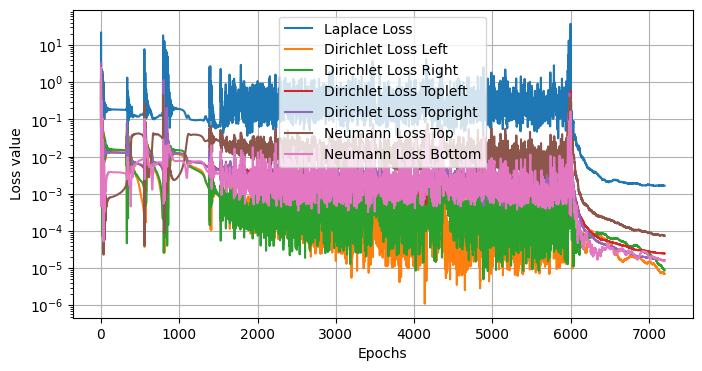

Epoch 7200, Total Loss: 7.255E+02, Domain Loss: 3.769E+01, Boundary Loss Dirichlet toppleft: 2.173E-01


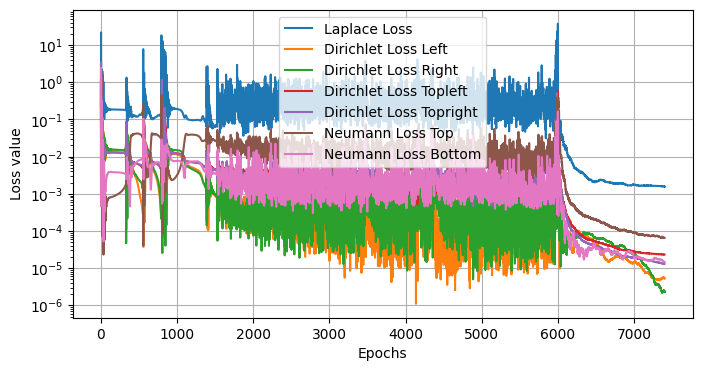

Epoch 7400, Total Loss: 7.255E+02, Domain Loss: 3.769E+01, Boundary Loss Dirichlet toppleft: 2.173E-01


In [ ]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]  # Change Tanh to GeLU
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())  # Change Tanh to GeLU
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

def loss_neumann_boundary(model,boundary_points,axis='horizontal'):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
    if axis=='vertical':
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    elif axis=='horizontal':
        u_y = u_grad[:,1] # This is the y-component of the gradient of u
        return torch.mean((u_y)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head=None):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    if head is not None:
        boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
        return boundary_points, boundary_targets
    else:
        return boundary_points

def plot_losses(epochs, losses_dict):
    plt.figure(figsize=(8, 4))
    
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epochs, loss_values, label=loss_name)
    
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()

#_____________________________________________________________________________________________________________

#Domain size:
left, right, bottom, top = 0, 1, 0, 0.2

left_dirichlet,target_left_dirichlet = create_boundary_points('vertical', left, 0, top, 1000, 1)  # Left boundary
boundary_points_dirichlet_left=torch.cat([left_dirichlet],dim=0).requires_grad_(True)  # Concatenate Dirichlet boundary points
target_points_dirichlet_left=torch.cat([target_left_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

right_dirichlet, target_right_dirichlet = create_boundary_points('vertical', right, 0, top, 1000, 0) # Right boundary
boundary_points_dirichlet_right=torch.cat([right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary points
target_points_dirichlet_right=torch.cat([target_right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

topleft_dirichlet, target_topleft_dirichlet= create_boundary_points('horizontal', top, 0, 0.3*right, 5000, 1)
boundary_points_dirichlet_topleft=torch.cat([topleft_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topleft=torch.cat([target_topleft_dirichlet],dim=0).requires_grad_(True)

topright_dirichlet,target_topright_dirichlet = create_boundary_points('horizontal', top, 0.7*right, 1*right, 5000, 0)
boundary_points_dirichlet_topright=torch.cat([topright_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topright=torch.cat([target_topright_dirichlet],dim=0).requires_grad_(True)

top_neumann=create_boundary_points('horizontal', top, 0.3*right, 0.7*right, 2000)
boundary_points_neumann_top=torch.cat([top_neumann],dim=0).requires_grad_(True)

bottom_neumann=create_boundary_points('horizontal', bottom, 0, right, 2000)
boundary_points_neumann_bottom=torch.cat([bottom_neumann],dim=0).requires_grad_(True)


# Creating domain points
num_domain_points=10000
x_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
x = (x_points*right).requires_grad_(True)
y_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
y=(y_points*top).requires_grad_(True)
train_points=torch.cat([x,y],dim=1) 

# Initialize lists to store losses and plot
laplace_losses = []
dirichlet_losses_left = []
dirichlet_losses_right = []
dirichlet_losses_topleft = []
dirichlet_losses_topright = []
neumann_losses_top = []
neumann_losses_bottom = []
epochs_recorded = []


#Defining changeable parameters:
model=pinn(hidden_size=40, hidden_layers=8) # to be used for evaluating u at boundaries and inside the domain
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Using the Adam optimizer #amsgrad=True
lbfgs_optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=40) #Using the Adam optimizer
lambda_laplace, y_d_l, y_d_r, y_d_tl, y_d_tr, y_n_t, y_n_b = 10,100,100,1000,1000,100,100

epochs=7501

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)  # Use Xavier initialization
        nn.init.zeros_(m.bias)  # Initialize biases to zero

# Apply weight initialization
model.apply(initialize_weights)
#Training loop:
for epoch in range(epochs):
    optimizer = adam_optimizer if epoch < 6000 else lbfgs_optimizer
   
    def closure():
        optimizer.zero_grad()  # Clear previous gradients
        loss_laplace=laplace_residual(model,train_points)

        loss_d_l = loss_dirichlet_boundary(model, boundary_points_dirichlet_left, target_points_dirichlet_left)
        loss_d_r = loss_dirichlet_boundary(model, boundary_points_dirichlet_right, target_points_dirichlet_right)
        loss_d_tl = loss_dirichlet_boundary(model, boundary_points_dirichlet_topleft, target_points_dirichlet_topleft)
        loss_d_tr = loss_dirichlet_boundary(model, boundary_points_dirichlet_topright, target_points_dirichlet_topright)

        loss_n_t = loss_neumann_boundary(model, boundary_points_neumann_top, axis='horizontal')
        loss_n_b = loss_neumann_boundary(model, boundary_points_neumann_bottom, axis='horizontal')

        # Add other boundary losses if needed
        loss = loss_d_l * y_d_l + loss_d_r * y_d_r + loss_d_tl * y_d_tl + loss_d_tr * y_d_tr + loss_n_t * y_n_t + loss_n_b * y_n_b + loss_laplace * lambda_laplace
   
        loss.backward()  # Compute gradients
        
        # Append losses to the lists
        laplace_losses.append(loss_laplace.item()) 
        dirichlet_losses_left.append(loss_d_l.item())
        dirichlet_losses_right.append(loss_d_r.item())
        dirichlet_losses_topleft.append(loss_d_tl.item())
        dirichlet_losses_topright.append(loss_d_tr.item())
        neumann_losses_top.append(loss_n_t.item())
        neumann_losses_bottom.append(loss_n_b.item())
        
        epochs_recorded.append(epoch) 


        return loss

    # Step with LBFGS, passing in the closure

    if isinstance(optimizer, torch.optim.LBFGS):
        optimizer.step(closure)
    else:
        optimizer.zero_grad() #Have to zero the gradients at the start of each epoch
        #losses
        loss_laplace=laplace_residual(model,train_points)

        loss_d_l = loss_dirichlet_boundary(model, boundary_points_dirichlet_left, target_points_dirichlet_left)
        loss_d_r = loss_dirichlet_boundary(model, boundary_points_dirichlet_right, target_points_dirichlet_right)
        loss_d_tl = loss_dirichlet_boundary(model, boundary_points_dirichlet_topleft, target_points_dirichlet_topleft)
        loss_d_tr = loss_dirichlet_boundary(model, boundary_points_dirichlet_topright, target_points_dirichlet_topright)

        loss_n_t = loss_neumann_boundary(model, boundary_points_neumann_top, axis='horizontal')
        loss_n_b = loss_neumann_boundary(model, boundary_points_neumann_bottom, axis='horizontal')

        loss = loss_d_l * y_d_l + loss_d_r * y_d_r + loss_d_tl * y_d_tl + loss_d_tr * y_d_tr + loss_n_t * y_n_t + loss_n_b * y_n_b + loss_laplace * lambda_laplace

        # Backward pass
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #Clipping the gradients
        optimizer.step() # Update

        # Append losses to the lists
        laplace_losses.append(loss_laplace.item()) 
        dirichlet_losses_left.append(loss_d_l.item())
        dirichlet_losses_right.append(loss_d_r.item())
        dirichlet_losses_topleft.append(loss_d_tl.item())
        dirichlet_losses_topright.append(loss_d_tr.item())
        neumann_losses_top.append(loss_n_t.item())
        neumann_losses_bottom.append(loss_n_b.item())
        
        epochs_recorded.append(epoch) 

    # scheduler.step(loss)

    # Logging
    if optimizer == adam_optimizer and epoch % 2000 == 0:
        losses_dict = {
            "Laplace Loss": laplace_losses,
            "Dirichlet Loss Left": dirichlet_losses_left,
            "Dirichlet Loss Right": dirichlet_losses_right,
            "Dirichlet Loss Topleft": dirichlet_losses_topleft,
            "Dirichlet Loss Topright": dirichlet_losses_topright,
            "Neumann Loss Top": neumann_losses_top,
            "Neumann Loss Bottom": neumann_losses_bottom
        }

        plot_losses(epochs_recorded, losses_dict)

        print(f"Epoch {epoch}, Total Loss: {loss.item():.3E}, Domain Loss: {loss_laplace.item():.3E}, Boundary Loss Dirichlet toppleft: {loss_d_tl.item():.3E}")
        # plot_losses(epochs_recorded, laplace_losses, loss_d_l, neumann_losses, total_losses)
    if optimizer == lbfgs_optimizer and epoch % 200 == 0:
        losses_dict = {
            "Laplace Loss": laplace_losses,
            "Dirichlet Loss Left": dirichlet_losses_left,
            "Dirichlet Loss Right": dirichlet_losses_right,
            "Dirichlet Loss Topleft": dirichlet_losses_topleft,
            "Dirichlet Loss Topright": dirichlet_losses_topright,
            "Neumann Loss Top": neumann_losses_top,
            "Neumann Loss Bottom": neumann_losses_bottom
        }

        plot_losses(epochs_recorded, losses_dict)

        print(f"Epoch {epoch}, Total Loss: {loss.item():.3E}, Domain Loss: {loss_laplace.item():.3E}, Boundary Loss Dirichlet toppleft: {loss_d_tl.item():.3E}")
        # plot_losses(epochs_recorded, laplace_losses, loss_d_l, neumann_losses, total_losses)

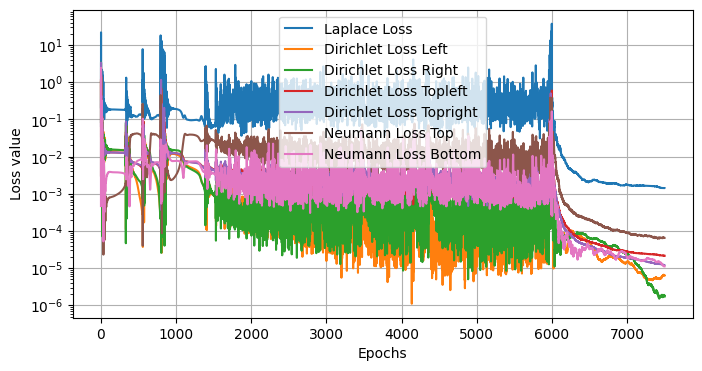

In [8]:
plot_losses(epochs_recorded, losses_dict)

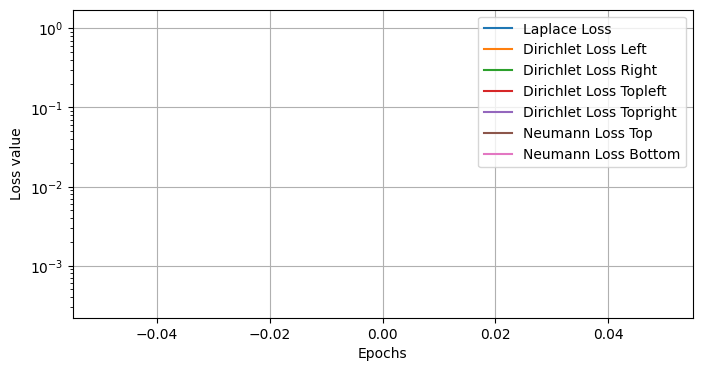

Epoch: 0 Loss weights: [1.0000000e+00 2.9574774e+02 1.0000000e+00 1.2117214e+03 9.0008960e+02
 4.4427906e+01 4.6691429e+01]
Normalized losses: []


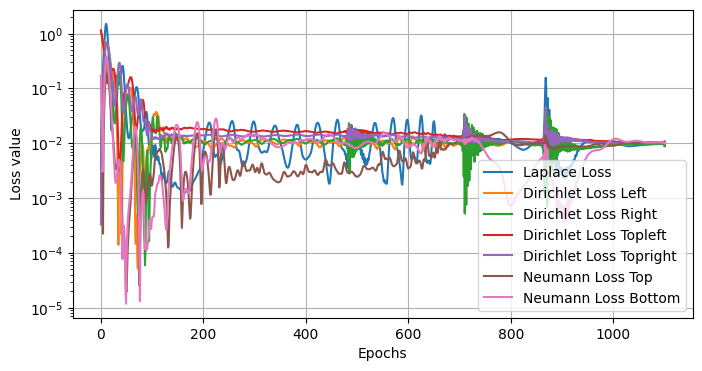

Epoch: 1100 Loss weights: [  561.2348   643.7357  1188.9326 10000.      9961.604   3022.0789
   919.587 ]


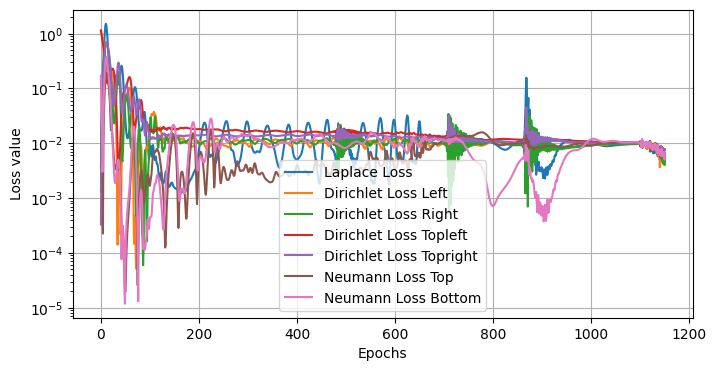

Epoch: 1150 Loss weights: [1.1282686e+03 1.0000000e+00 1.0000000e+00 4.2485913e+03 1.0000000e+04
 2.9162532e+03 1.6161669e+03]


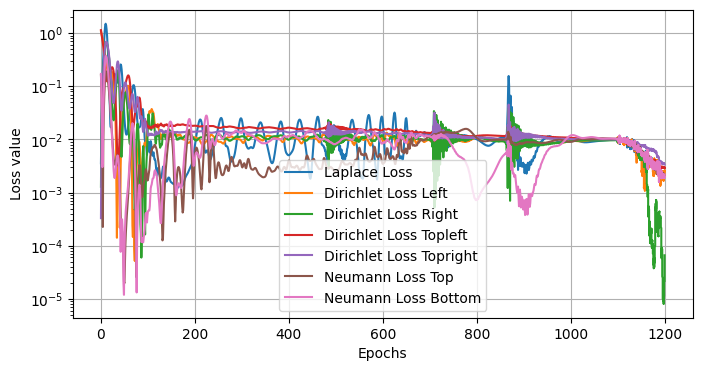

Epoch: 1200 Loss weights: [3.3200303e+03 6.8917358e+02 1.0000000e+00 1.0000000e+04 1.0000000e+04
 6.9431729e+03 3.3181900e+02]


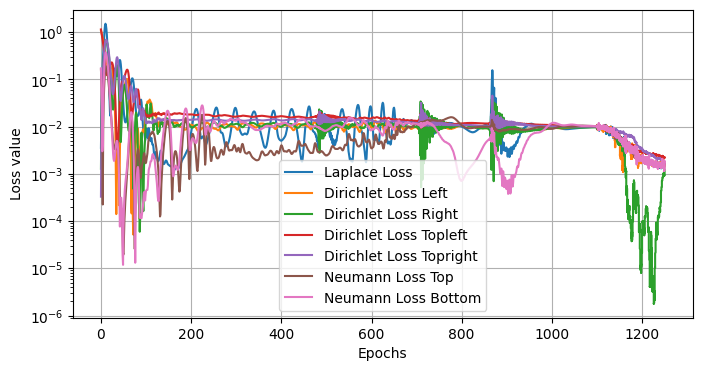

Epoch: 1250 Loss weights: [3.817903e+03 4.094690e+02 1.000000e+00 1.000000e+04 1.000000e+04
 5.500204e+03 2.936994e+02]


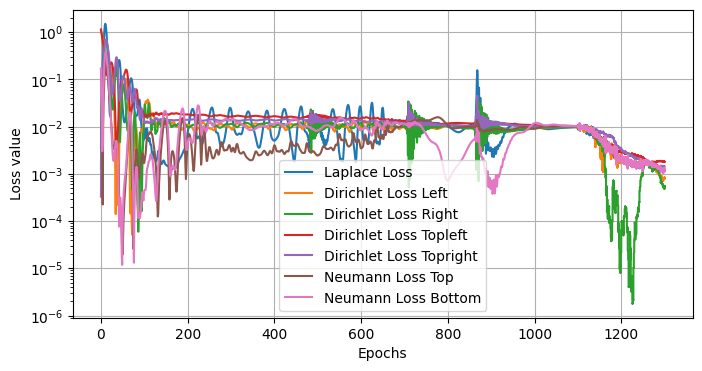

Epoch: 1300 Loss weights: [6.2985117e+03 1.0000000e+00 1.0000000e+00 1.0000000e+04 1.0000000e+04
 4.8913745e+03 8.2809961e+02]


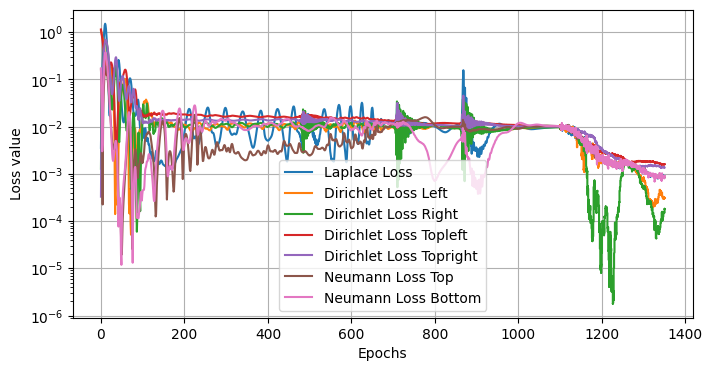

Epoch: 1350 Loss weights: [6.4030405e+03 1.0000000e+00 1.0000000e+00 1.0000000e+04 1.0000000e+04
 8.1216816e+03 6.3678979e+02]


KeyboardInterrupt: 

In [ ]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]  # Change Tanh to GeLU
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())  # Change Tanh to GeLU
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

def loss_neumann_boundary(model,boundary_points,axis='horizontal'):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
    if axis=='vertical':
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    elif axis=='horizontal':
        u_y = u_grad[:,1] # This is the y-component of the gradient of u
        return torch.mean((u_y)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head=None):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    if head is not None:
        boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
        return boundary_points, boundary_targets
    else:
        return boundary_points

def plot_losses(epochs, losses_dict):
    plt.figure(figsize=(8, 4))
    
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epochs, loss_values, label=loss_name)
    
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()


def closure():
    global loss_weights  # Make loss_weights modifiable in this function
    
    optimizer.zero_grad()  # Clear previous gradients

    # Compute individual loss terms
    loss_laplace = laplace_residual(model, train_points)
    loss_d_l = loss_dirichlet_boundary(model, boundary_points_dirichlet_left, target_points_dirichlet_left)
    loss_d_r = loss_dirichlet_boundary(model, boundary_points_dirichlet_right, target_points_dirichlet_right)
    loss_d_tl = loss_dirichlet_boundary(model, boundary_points_dirichlet_topleft, target_points_dirichlet_topleft)
    loss_d_tr = loss_dirichlet_boundary(model, boundary_points_dirichlet_topright, target_points_dirichlet_topright)
    loss_n_t = loss_neumann_boundary(model, boundary_points_neumann_top, axis='horizontal')
    loss_n_b = loss_neumann_boundary(model, boundary_points_neumann_bottom, axis='horizontal')
    
    # Compute mean loss for normalization
    mean_loss = (loss_laplace + loss_d_l + loss_d_r + loss_d_tl + loss_d_tr + loss_n_t + loss_n_b) / 7
    normalized_losses = torch.tensor(
        [loss_laplace, loss_d_l, loss_d_r, loss_d_tl, loss_d_tr, loss_n_t, loss_n_b],
        dtype=torch.float
    ) / mean_loss



    # Combine losses using the updated weights
    loss = (
        loss_weights[0] * loss_laplace +
        loss_weights[1] * loss_d_l +
        loss_weights[2] * loss_d_r +
        loss_weights[3] * loss_d_tl +
        loss_weights[4] * loss_d_tr +
        loss_weights[5] * loss_n_t +
        loss_weights[6] * loss_n_b
    )

    # Backpropagate the total loss to update the model
    loss.backward()
    
    # Record losses and weights
    laplace_losses.append(loss_laplace.item())
    dirichlet_losses_left.append(loss_d_l.item())
    dirichlet_losses_right.append(loss_d_r.item())
    dirichlet_losses_topleft.append(loss_d_tl.item())
    dirichlet_losses_topright.append(loss_d_tr.item())
    neumann_losses_top.append(loss_n_t.item())
    neumann_losses_bottom.append(loss_n_b.item())
    epochs_recorded.append(epoch)
    loss_weights_recorded.append(loss_weights.detach().clone())

    # Update loss weights with damping and clipping
    # if epoch%1==0:
    with torch.no_grad():
        loss_weights = loss_weights + (normalized_losses-1)*100
        loss_weights = torch.clamp(loss_weights, min=1, max=10000)

    return loss



#_____________________________________________________________________________________________________________

#Domain size:
left, right, bottom, top = 0, 1, 0, 0.2

left_dirichlet,target_left_dirichlet = create_boundary_points('vertical', left, 0, top, 1000, 1)  # Left boundary
boundary_points_dirichlet_left=torch.cat([left_dirichlet],dim=0).requires_grad_(True)  # Concatenate Dirichlet boundary points
target_points_dirichlet_left=torch.cat([target_left_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

right_dirichlet, target_right_dirichlet = create_boundary_points('vertical', right, 0, top, 1000, 0) # Right boundary
boundary_points_dirichlet_right=torch.cat([right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary points
target_points_dirichlet_right=torch.cat([target_right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

topleft_dirichlet, target_topleft_dirichlet= create_boundary_points('horizontal', top, 0, 0.3*right, 2000, 1)
boundary_points_dirichlet_topleft=torch.cat([topleft_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topleft=torch.cat([target_topleft_dirichlet],dim=0).requires_grad_(True)

topright_dirichlet,target_topright_dirichlet = create_boundary_points('horizontal', top, 0.7*right, 1*right, 2000, 0)
boundary_points_dirichlet_topright=torch.cat([topright_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topright=torch.cat([target_topright_dirichlet],dim=0).requires_grad_(True)

top_neumann=create_boundary_points('horizontal', top, 0.3*right, 0.7*right, 1000)
boundary_points_neumann_top=torch.cat([top_neumann],dim=0).requires_grad_(True)

bottom_neumann=create_boundary_points('horizontal', bottom, 0, right, 1000)
boundary_points_neumann_bottom=torch.cat([bottom_neumann],dim=0).requires_grad_(True)


# Creating domain points
num_domain_points=10000
x_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
x = (x_points*right).requires_grad_(True)
y_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
y=(y_points*top).requires_grad_(True)
train_points=torch.cat([x,y],dim=1) 

# Initialize lists to store losses and plot
laplace_losses = []
dirichlet_losses_left = []
dirichlet_losses_right = []
dirichlet_losses_topleft = []
dirichlet_losses_topright = []
neumann_losses_top = []
neumann_losses_bottom = []
epochs_recorded = []

loss_weights_recorded=[]
normalized_losses_recorded=[]


#Defining changeable parameters:
model=pinn(hidden_size=20, hidden_layers=8) # to be used for evaluating u at boundaries and inside the domain
# adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Using the Adam optimizer #amsgrad=True
# lbfgs_optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=40) #Using the Adam optimizer
lambda_laplace, y_d_l, y_d_r, y_d_tl, y_d_tr, y_n_t, y_n_b = 10,100,100,1000,1000,100,100

epochs=1401

# Add trainable weights for each loss term
loss_weights =(torch.tensor([lambda_laplace, y_d_l, y_d_r, y_d_tl, y_d_tr, y_n_t, y_n_b], 
                            dtype=torch.float, requires_grad=False))

adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lbfgs_optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=40)


def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)  # Use Xavier initialization
        nn.init.zeros_(m.bias)  # Initialize biases to zero

# Apply weight initialization
model.apply(initialize_weights)
#Training loop:
for epoch in range(epochs):
    optimizer = adam_optimizer if epoch < 1100 else lbfgs_optimizer
   
    if isinstance(optimizer, torch.optim.LBFGS):
        optimizer.step(closure)
    else:
        loss=closure()
        optimizer.step() # Update
        #autograd.grad(loss, loss_weights[0])
        

    # Logging
    if optimizer == adam_optimizer and epoch % 1100 == 0:
        losses_dict = {
            "Laplace Loss": laplace_losses,
            "Dirichlet Loss Left": dirichlet_losses_left,
            "Dirichlet Loss Right": dirichlet_losses_right,
            "Dirichlet Loss Topleft": dirichlet_losses_topleft,
            "Dirichlet Loss Topright": dirichlet_losses_topright,
            "Neumann Loss Top": neumann_losses_top,
            "Neumann Loss Bottom": neumann_losses_bottom
        }

        plot_losses(epochs_recorded, losses_dict)
        print("Epoch:",epoch, "Loss weights:", loss_weights.detach().numpy())
        print(f"Normalized losses: {normalized_losses_recorded}")


    if optimizer == lbfgs_optimizer and epoch % 50 == 0:
        losses_dict = {
            "Laplace Loss": laplace_losses,
            "Dirichlet Loss Left": dirichlet_losses_left,
            "Dirichlet Loss Right": dirichlet_losses_right,
            "Dirichlet Loss Topleft": dirichlet_losses_topleft,
            "Dirichlet Loss Topright": dirichlet_losses_topright,
            "Neumann Loss Top": neumann_losses_top,
            "Neumann Loss Bottom": neumann_losses_bottom
        }

        plot_losses(epochs_recorded, losses_dict)

        print("Epoch:",epoch, "Loss weights:", loss_weights.detach().numpy())


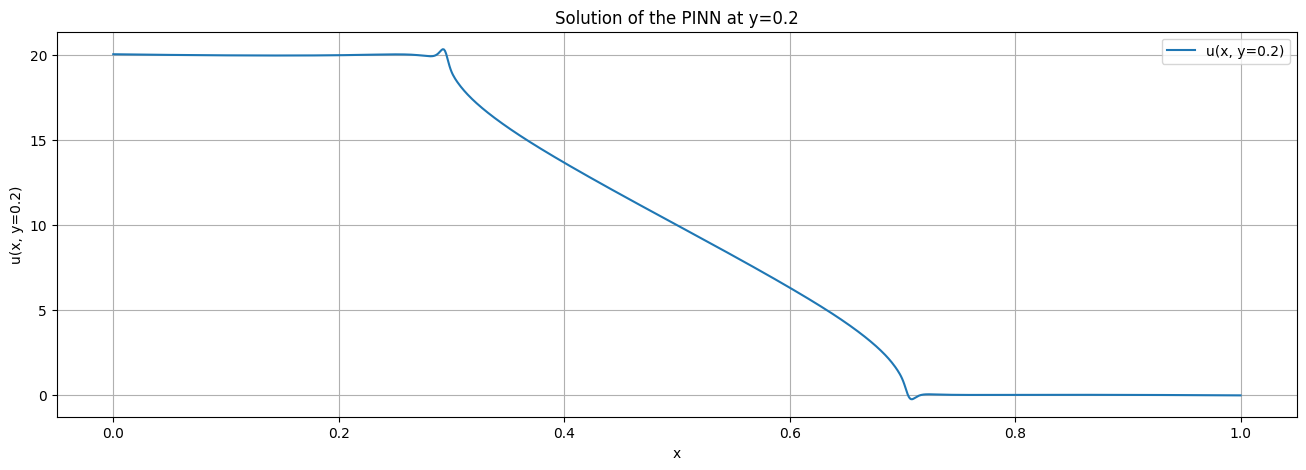

In [13]:
# Define the x values (0 to 1) and keep y fixed at 0.2
x = np.linspace(0, 1, 1000)  # 1000 points along x
y = np.full_like(x, 0.2)     # Keep y constant at 0.2

# Combine x and y into points for evaluation
points = torch.tensor(np.c_[x, y], dtype=torch.float32)

# Evaluate the model
solution = 20* model(points).detach().numpy()

# Plot the solution
plt.figure(figsize=(16, 5))
plt.plot(x, solution, label="u(x, y=0.2)")
plt.title("Solution of the PINN at y=0.2")
plt.xlabel("x")
plt.ylabel("u(x, y=0.2)")
plt.grid()
plt.legend()
plt.show()

In [11]:
# Assume `model` is your trained instance of the `pinn` class
model_path = "trained_pinn_model_dynweights.pth"
torch.save(model.state_dict(), model_path)
print(f"Model's state dictionary saved to {model_path}")

Model's state dictionary saved to trained_pinn_model_dynweights.pth


In [ ]:
# Assume `model` is your trained instance of the `pinn` class
model_path = "trained_pinn_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model's state dictionary saved to {model_path}")

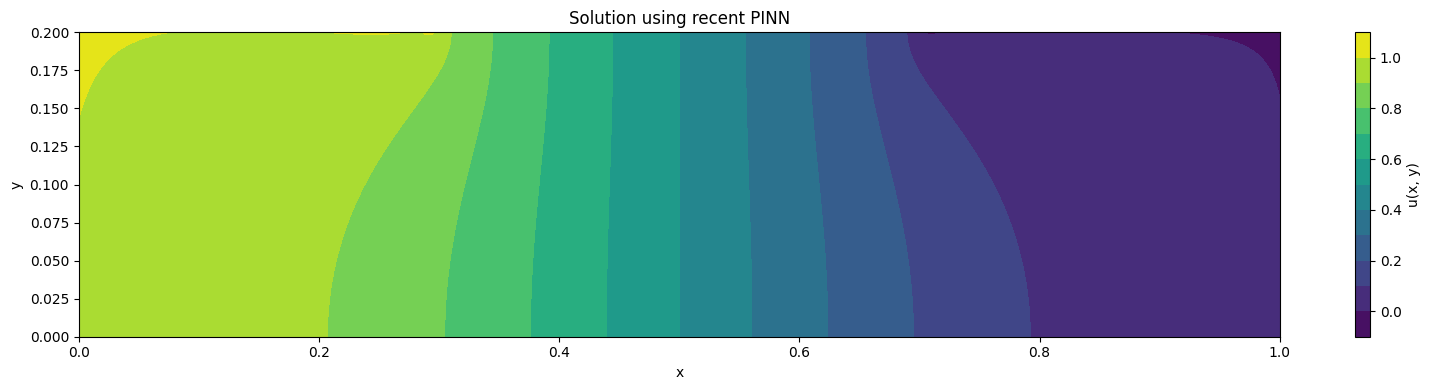

In [10]:
# Plot the results
num=100
x = torch.linspace(0, right, 600)
y=torch.linspace(0, top, 200)
X, Y = torch.meshgrid(x, y)
test_points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# PINN solution
predicted_u = model(test_points).detach().numpy().reshape(600, 200) #detach, numpy are used to convert the tensor to numpy array, reshape to coordinates.

plt.figure(figsize=(16, 4))

# PINN solution plot
plt.contourf(X.numpy(), Y.numpy(), predicted_u, 10, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution using recent PINN")

plt.tight_layout()
plt.show()

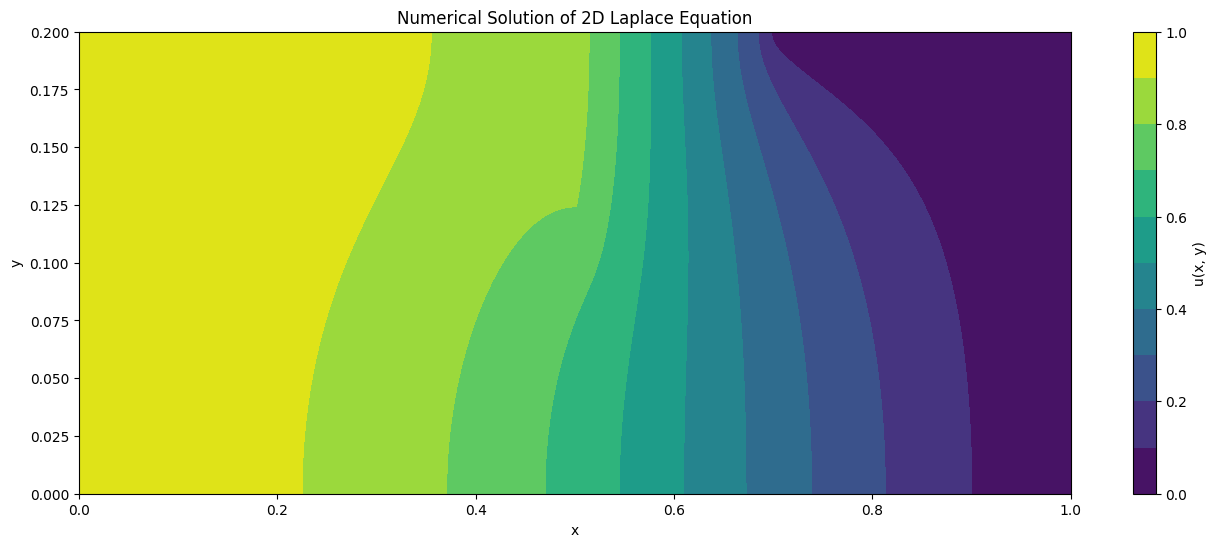

In [19]:
# Domain parameters
left, right, bottom, top = 0, 1, 0, 0.2
Lx, Ly = right,top  # Domain size in x and y
Nx, Ny = 300, 100  # Number of grid points
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Grid spacing
tolerance = 1e-6  # Convergence tolerance

# Boundary conditions
def f(y): return 1  # u(0, y) = f(y)
def s(x): return 0  # u(x, 1) = q(x)

# Initialize the solution grid with zeros
u = np.zeros((Nx, Ny))

# Apply boundary conditions
u[0:int(0.3*Nx),-1] = f(np.linspace(0, Lx, Nx))  # Top boundary
u[int(0.7*Nx):Nx,-1] = s(np.linspace(0, Lx, Nx))  # Top boundary
u[0, :] = f(np.linspace(0, Ly, Ny))  # Left boundary
u[-1, :] = s(np.linspace(0, Ly, Ny))  # Right boundary

# Neumann condition (no flow) on the top and bottom boundaries
u[int(0.3*Nx):int(0.7*Nx), -1] = u[int(0.3*Nx):int(0.7*Nx), -2]    # Top boundary, ∂u/∂y = 0
u[0:Nx, 0] = u[0:Nx, 1]      # Bottom boundary, ∂u/∂y = 0
u[int(0.5*Nx), int(0.5*Ny):Ny] = u[int(0.5*Nx)+1, int(0.5*Ny):Ny]
u[int(0.5*Nx), int(0.5*Ny):Ny] = u[int(0.5*Nx)-1, int(0.5*Ny):Ny]

# Iterative solution using the finite difference method
error = 1.0  # Initialize error
while error > tolerance:
    u_old = u.copy()
    
    # Update the interior points using the finite difference scheme
    u[1:-1, 1:-1] = 0.25 * (u_old[2:, 1:-1] + u_old[:-2, 1:-1] +
                            u_old[1:-1, 2:] + u_old[1:-1, :-2])

    # Neumann condition (no flow in x-direction at x = 1): ∂u/∂x = 0
    u[int(0.3*Nx):int(0.7*Nx), -1] = u[int(0.3*Nx):int(0.7*Nx), -2]    # Top boundary, ∂u/∂y = 0
    u[0:Nx, 0] = u[0:Nx, 1]      # Bottom boundary, ∂u/∂y = 0
    u[int(0.5*Nx), int(0.5*Ny):Ny] = u[int(0.5*Nx)+1, int(0.5*Ny):Ny]
    u[int(0.5*Nx), int(0.5*Ny):Ny] = u[int(0.5*Nx)-1, int(0.5*Ny):Ny]

    # Compute the error as the maximum difference between old and new values
    error = np.max(np.abs(u - u_old))

# Plot the results
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))
plt.figure(figsize=(16, 6))
plt.contourf(X, Y, u.T, 10, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical Solution of 2D Laplace Equation")
plt.show()

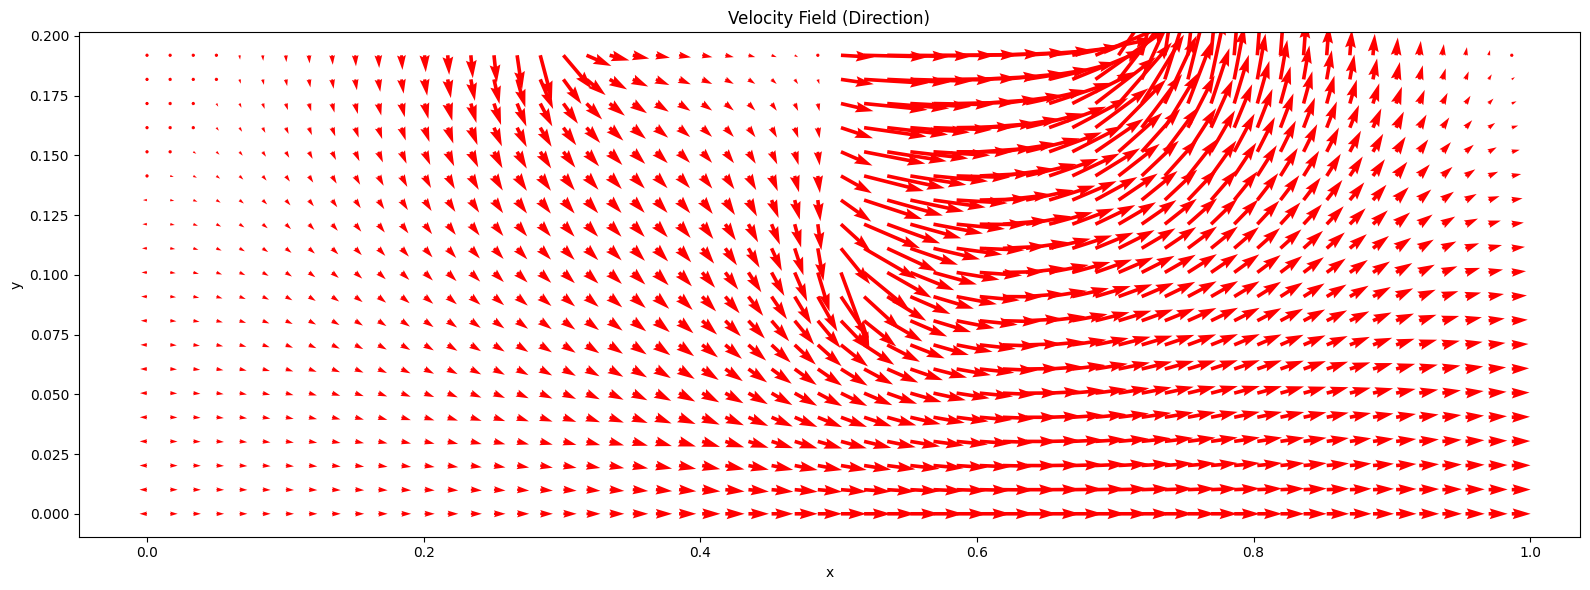

In [20]:
# Define the downsampling rate for the arrows
pil_x = 60  # Number of arrows in x and y directions
pil_y = 20 # Number of arrows in x and y directions
K=1

# Compute velocity field (v_x and v_y) from the gradient of u
v_x = np.zeros_like(u)
v_y = np.zeros_like(u)

# Central differences for interior points
v_x[1:-1, :] = (u[2:, :] - u[:-2, :]) / (2 * dx)
v_y[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2 * dy)

# Forward/backward differences for boundaries
v_x[0, :] = -K*(u[1, :] - u[0, :]) / dx  # Left boundary
v_x[-1, :] = -K*(u[-1, :] - u[-2, :]) / dx  # Right boundary
v_y[:, 0] = -K*(u[:, 1] - u[:, 0]) / dy  # Bottom boundary
v_y[:, -1] = -K*(u[:, -1] - u[:, -2]) / dy  # Top boundary

# Full grid for plotting the potential field
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))

# Downsample for arrow plotting
step_x = Nx // pil_x
step_y = Ny // pil_y
X_downsampled = X[::step_x, ::step_y]
Y_downsampled = Y[::step_x, ::step_y]
v_x_downsampled = v_x[::step_x, ::step_y]
v_y_downsampled = v_y[::step_x, ::step_y]

# Plot the potential field
plt.figure(figsize=(16, 6))

# Plot the velocity field (direction and magnitude) on downsampled grid
plt.quiver(X_downsampled, Y_downsampled, -v_x_downsampled.T, -v_y_downsampled.T, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Velocity Field (Direction)")

plt.tight_layout()
plt.show()

In [ ]:
print(u[int(0.3*Nx), int(0.5*Ny):Ny] - u[int(0.3*Nx)+1, int(0.5*Ny):Ny])

In [ ]:
# Load the saved data
u_saved='u_saved.npy'
u_FDM= np.load(u_saved)


In [ ]:
# Domain parameters
left, right, bottom, top = 0, 1, 0, 0.3
Lx, Ly = right,top  # Domain size in x and y
Nx, Ny = 600, 200  # Number of grid points

In [ ]:
# Plot the results
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))
plt.figure(figsize=(20, 6))
plt.contourf(X, Y, u_FDM.T, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical Solution of 2D Laplace Equation")
plt.show()

In [ ]:
# Plot the results
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u.T, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical Solution of 2D Laplace Equation")
plt.show()

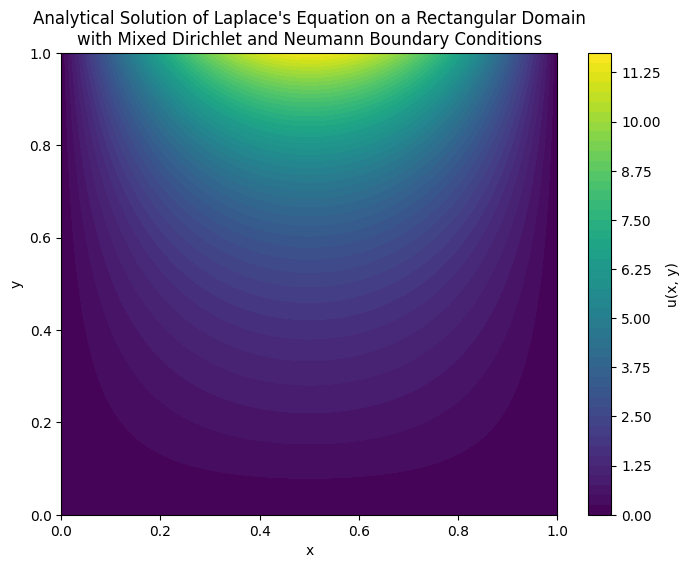

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define the domain
L, H = 1, 1  # Length of the rectangle in x and y directions
num_points = 100

x = np.linspace(0, L, num_points)
y = np.linspace(0, H, num_points)
X, Y = np.meshgrid(x, y)

# Define the analytical solution
U = np.sinh(np.pi * Y / L) * np.sin(np.pi * X / L)

# Plot the analytical solution
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, U, levels=50, cmap="viridis")
plt.colorbar(cp, label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution of Laplace's Equation on a Rectangular Domain\n"
          "with Mixed Dirichlet and Neumann Boundary Conditions")
plt.show()


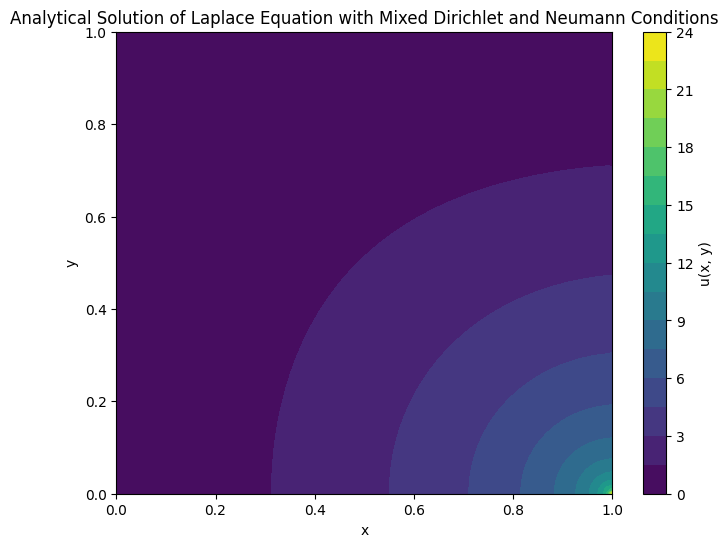

0.0
Maximum value in u is located at index: (0, 99)


In [16]:
import numpy as np
import matplotlib.pyplot as plt

def analytical_solution_mixed_boundaries(x, y, U=1.0, L=1.0, W=1.0, num_terms=50):
    """
    Computes the analytical solution of the Laplace equation on a rectangular domain
    with Dirichlet boundary conditions on the left and right, and Neumann boundary conditions on the top and bottom.

    Parameters:
        x (np.ndarray): x-coordinates (2D array)
        y (np.ndarray): y-coordinates (2D array)
        U (float): Potential on the right boundary (default is 1.0)
        L (float): Width of the rectangle in the x direction
        W (float): Height of the rectangle in the y direction
        num_terms (int): Number of terms in the series for approximation (default is 50)

    Returns:
        np.ndarray: Analytical solution for u(x, y) on the given grid
    """
    u = np.zeros_like(x)
    for n in range(num_terms):
        A_n = (4 * U) / (np.pi * (2 * n + 1))
        term = A_n * np.cos((2 * n + 1) * np.pi * y / (2 * W)) * \
               (np.sinh((2 * n + 1) * np.pi * x / (2 * W)) / np.sinh((2 * n + 1) * np.pi * L / (2 * W)))
        u += term
    return u

# Set up the domain
L, W = 1.0, 1.0  # Domain dimensions
Nx, Ny = 100, 100  # Number of points in x and y directions
x = np.linspace(0, L, Nx)
y = np.linspace(0, W, Ny)
X, Y = np.meshgrid(x, y)

# Compute the solution
U = 5.0
u = analytical_solution_mixed_boundaries(X, Y, U=U, L=L, W=W, num_terms=200)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution of Laplace Equation with Mixed Dirichlet and Neumann Conditions")
plt.show()
print((u[1,0]))
max_index = np.unravel_index(np.argmax(u, axis=None), u.shape)
print(f"Maximum value in u is located at index: {max_index}")

In [ ]:
ind = find(M:):
L=L(ind,ind)
n=b(ind)
u=L/b
U=zeros(Nx,Ny)|
U(ind)=u


### Problem Setup

1. **Domain**:
   - **Depth**: 10 meters (from ground surface to bedrock).
   - **Excavation Depth**: 4 meters deep, with water pumped out to the bottom level of the pit.
   - **Width of Domain**: 2.5 meters (using symmetry for the 5-meter width of the pit).

2. **Boundary Conditions**:
   - **Ground Surface Boundary (Outside the Pit)**: Water head is set to the ground surface level (10 meters).
   - **Excavation Pit Floor**: Water head inside the excavation pit is at the bottom of the pit, so 4 meters below the surface.
   - **Sheet Pile Wall (Impermeable Boundary)**: This boundary goes down 6 meters, creating a no-flow condition along this section.
   - **Bedrock (Impermeable)**: The bedrock at 10 meters depth is also impermeable, leading to a no-flow condition.

3. **Symmetry Boundary Condition**:
   - Along the symmetry line (middle of the pit), there is no lateral flow, which results in a no-flow (Neumann) boundary condition.


### Boundary Conditions

1. **Ground Surface Boundary (Outside the Pit)**: 
   - The water head is set to the ground surface level, which is 10 meters.
   - Boundary condition: $u(x, 0) = 10$.

2. **Excavation Pit Floor**: 
   - The water head inside the excavation pit is at the bottom of the pit, 4 meters below the surface.
   - Boundary condition: $u(x, -4) = 4$.

3. **Sheet Pile Wall (Impermeable Boundary)**: 
   - The wall extends down to 6 meters, creating a no-flow condition along this section.
   - Boundary condition: $\frac{\partial u}{\partial x} = 0$ along the wall from 0 to 6 meters depth.

4. **Bedrock (Impermeable)**: 
   - The bedrock at 10 meters depth is impermeable, leading to a no-flow condition.
   - Boundary condition: $\frac{\partial u}{\partial y} = 0$ at 10 meters depth.

5. **Symmetry Boundary Condition**: 
   - Along the symmetry line (middle of the excavation pit), there is no lateral flow, resulting in a no-flow condition.
   - Boundary condition: $\frac{\partial u}{\partial x} = 0$ along the symmetry boundary.



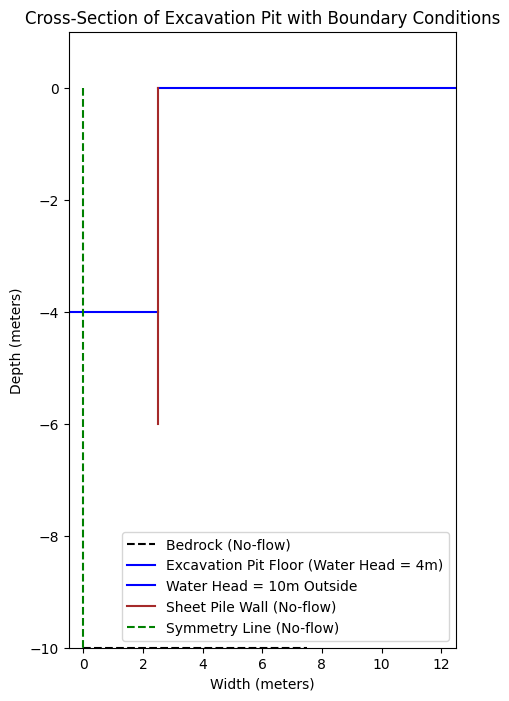

In [15]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 8))

# Define coordinates for different regions and boundaries
# Excavation pit
excavation_depth = -4
pit_width_half = 2.5  # Half-width due to symmetry

# Bedrock depth
bedrock_depth = -10

# Sheet pile wall
sheet_pile_depth = -6
sheet_pile_x = pit_width_half

# Water levels
water_outside = 0  # Groundwater level outside the pit
water_inside = -4    # Groundwater level inside the pit at bottom of excavation

# Draw bedrock line
ax.plot([0, 7.5], [bedrock_depth, bedrock_depth], color='black', linestyle='--', label='Bedrock (No-flow)')

# Draw excavation pit walls and bottom
ax.plot([pit_width_half, -pit_width_half], [excavation_depth, excavation_depth], color='blue', label='Excavation Pit Floor (Water Head = 4m)')

# Draw water level outside
ax.plot([2.5, 2.5-bedrock_depth], [0, 0], color='blue', linestyle='-', label='Water Head = 10m Outside')

# Draw sheet pile wall
ax.plot([sheet_pile_x, sheet_pile_x], [0, sheet_pile_depth], color='brown', linestyle='-', label='Sheet Pile Wall (No-flow)')

# Draw symmetry line (no-flow boundary)
ax.plot([0, 0], [0, bedrock_depth], color='green', linestyle='--', label='Symmetry Line (No-flow)')

# Labels
ax.set_title("Cross-Section of Excavation Pit with Boundary Conditions")
ax.set_xlabel("Width (meters)")
ax.set_ylabel("Depth (meters)")
ax.set_xlim(-.5, 2.5-bedrock_depth)
ax.set_ylim(bedrock_depth, 1)

# Add legend
ax.legend(loc='lower right')

# Show the plot
plt.show()
